In [1]:
import json
import os
import requests
from glob import glob

import pandas as pd
from pandas.io.json import json_normalize
from sqlalchemy import create_engine
from tqdm import tqdm

%matplotlib inline

In [2]:
eng = create_engine('sqlite:///db/data.sqlite3', echo=False)

In [3]:
## Create directories
# !mkdir images
# !mkdir data
# !mkdir db

## Image metadata

In [4]:
## Download image metadata
# url = 'http://beyondwords.labs.loc.gov/data'
# r = requests.get(url, stream=True)
# with open('data/data.json', 'wb') as f:
#     for chunk in r.iter_content(): 
#         if chunk:
#             f.write(chunk)

In [5]:
# Load downloaded data
with open('data/data.json') as jsonfile:
    data = json.load(jsonfile)['data']

In [6]:
# Show a couple of data entries
data[:2]

[{'id': '59f0e2a52ef3300001002322',
  'location': {'standard': 'http://s3.amazonaws.com/ndnp-jpeg-surrogates/ohi_echo_ver01/data/sn88078751/00237282589/1917061901/0274.jpg'},
  'region': {'toolName': 'rectangleTool',
   'color': '#fe0000',
   'x': 267.9352864852792,
   'y': 2123.43418486819,
   'width': 659.8053042473791,
   'height': 1034.922970227556,
   'label': 'Illustration/Photo'},
  'width': 5188,
  'height': 6414,
  'meta_data': {'set_key': 'http://chroniclingamerica.loc.gov/lccn/sn88078751/1917-06-19/ed-1/seq-5/',
   'subject_url': 'http://chroniclingamerica.loc.gov/lccn/sn88078751/1917-06-19/ed-1/seq-5/',
   'subject_description': 'The Democratic banner. June 19, 1917. Page 5',
   'resize': '1.000000',
   'alto': 'http://s3.amazonaws.com/ndnp-batches/ohi_echo_ver01/data/sn88078751/00237282589/1917061901/0274.xml'},
  'data': {'values': [{'caption': 'REV. J. A. LONG Pronounced Invocation and Benediction at the Memorial',
     'category': 'Photograph'}],
   'task_prompt': "Ente

In [7]:
# Restructure data for consistency: sometimes 
# the 'data' attribute is at root level; somtimes
# it's nested under a 'values' attribute
for i, doc in enumerate(data):
    values_attrib = doc['data'].get('values')
    if values_attrib: 
        data[i]['data'] = values_attrib[0]

In [8]:
# Flatten data into dataframe
df = json_normalize(data)
# json_normalize uses periods in col names; change to underscore
df.columns = df.columns.map(lambda x: x.replace('.', '_'))

# Show a couple of dataframe entries
df.head(3)

,data_caption,data_category,data_creator,height,id,location_standard,meta_data_alto,meta_data_resize,meta_data_set_key,meta_data_subject_description,meta_data_subject_url,region_color,region_height,region_label,region_toolName,region_width,region_x,region_y,width
0,REV. J. A. LONG Pronounced Invocation and Bene...,Photograph,NaN,6414,59f0e2a52ef3300001002322,http://s3.amazonaws.com/ndnp-jpeg-surrogates/o...,http://s3.amazonaws.com/ndnp-batches/ohi_echo_...,1.000000,http://chroniclingamerica.loc.gov/lccn/sn88078...,"The Democratic banner. June 19, 1917. Page 5",http://chroniclingamerica.loc.gov/lccn/sn88078...,#fe0000,1034.922970,Illustration/Photo,rectangleTool,659.805304,267.935286,2123.434185,5188
1,JUDGE P. A. BERRY\nSelected By Governor Cox To...,Photograph,NaN,6500,5b11aea6a042dd000100137b,http://s3.amazonaws.com/ndnp-jpeg-surrogates/o...,http://s3.amazonaws.com/ndnp-batches/ohi_echo_...,1.000000,http://chroniclingamerica.loc.gov/lccn/sn88078...,"The Democratic banner. June 08, 1917. Page 2",http://chroniclingamerica.loc.gov/lccn/sn88078...,#fe0000,1014.975042,Illustration/Photo,rectangleTool,662.231310,252.912460,2545.757072,5208
2,"New photograph of Premier Venizelos of Greece,...",Photograph,Western Newspaper Union,6560,5b11ac5a572c860001003d6b,http://s3.amazonaws.com/ndnp-jpeg-surrogates/o...,http://s3.amazonaws.com/ndnp-batches/ohi_echo_...,1.000000,http://chroniclingamerica.loc.gov/lccn/sn88078...,"The Democratic banner. December 18, 1917. Page 1",http://chroniclingamerica.loc.gov/lccn/sn88078...,#fe0000,1440.479854,Illustration/Photo,rectangleTool,639.833057,1036.730931,2220.597210,5300


In [9]:
# # Drop columns we probably won't need
# drop_cols = [
#     'meta_data_resize',
#     'region_color',
#     'region_toolName',
#     'region_label',
# ]
# for col in drop_cols:
#     df.drop(col, axis=1, inplace=True)

In [10]:
# Show data types inferred by pandas
df.dtypes

data_caption                      object
data_category                     object
data_creator                      object
height                             int64
id                                object
location_standard                 object
meta_data_alto                    object
meta_data_resize                  object
meta_data_set_key                 object
meta_data_subject_description     object
meta_data_subject_url             object
region_color                      object
region_height                    float64
region_label                      object
region_toolName                   object
region_width                     float64
region_x                         float64
region_y                         float64
width                              int64
dtype: object

In [11]:
# Convert NaNs in text columns to blanks
obj_cols = list(df.select_dtypes(include=['object']).columns)
for col in obj_cols:
    df[col] = df[col].fillna('')

In [12]:
# Get colum counts
df.count()

data_caption                     1749
data_category                    1749
data_creator                     1749
height                           1749
id                               1749
location_standard                1749
meta_data_alto                   1749
meta_data_resize                 1749
meta_data_set_key                1749
meta_data_subject_description    1749
meta_data_subject_url            1749
region_color                     1749
region_height                    1749
region_label                     1749
region_toolName                  1749
region_width                     1749
region_x                         1749
region_y                         1749
width                            1749
dtype: int64

In [13]:
# Add column that is an md5 hash of the image url,
# to use as a uniqe image id
import hashlib

# func to return hash for a string
def hashstr(s):
    return hashlib.md5(s.encode('utf8')).hexdigest()

# apply to new column
df['img_url_hash'] = df.apply(lambda r: hashstr(r['location_standard']), axis=1)

In [14]:
# Save data as sqlite db
df.to_sql('data', eng, index=False, if_exists='replace')

In [15]:
# Re-read data from sql and check data types
pd.read_sql("select * from data", eng).dtypes

data_caption                      object
data_category                     object
data_creator                      object
height                             int64
id                                object
location_standard                 object
meta_data_alto                    object
meta_data_resize                  object
meta_data_set_key                 object
meta_data_subject_description     object
meta_data_subject_url             object
region_color                      object
region_height                    float64
region_label                      object
region_toolName                   object
region_width                     float64
region_x                         float64
region_y                         float64
width                              int64
img_url_hash                      object
dtype: object

In [16]:
# Re-read data from sql and check counts
pd.read_sql("select * from data", eng).count()

data_caption                     1749
data_category                    1749
data_creator                     1749
height                           1749
id                               1749
location_standard                1749
meta_data_alto                   1749
meta_data_resize                 1749
meta_data_set_key                1749
meta_data_subject_description    1749
meta_data_subject_url            1749
region_color                     1749
region_height                    1749
region_label                     1749
region_toolName                  1749
region_width                     1749
region_x                         1749
region_y                         1749
width                            1749
img_url_hash                     1749
dtype: int64

## Image files

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f545438dd30>]],
      dtype=object)

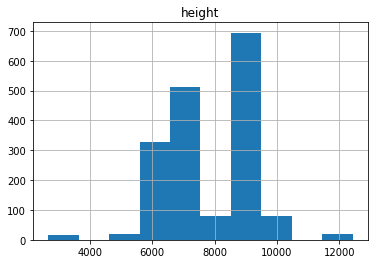

In [17]:
# Look at image heights
df.hist(column='height')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f54543d4d30>]],
      dtype=object)

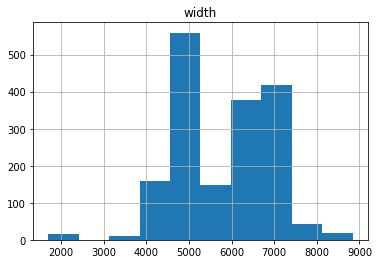

In [18]:
# look at image widths
df.hist(column='width')

In [19]:
from skimage import io, exposure, transform

In [20]:
# Download image corresponding to each unique image hash,
# process as necessary before saving
sql = "select distinct location_standard, img_url_hash from data"
img_list = list(eng.execute(sql))
for row in tqdm(img_list):
    uhash = row[1]
    url = row[0]
    # image filename is based on url hash
    path = 'images/{}.jpg'.format(uhash)
    # download, if file doesn't exist
    if not os.path.exists(path):
        img = io.imread(url)
        # original files are pretty big: scale to manageable size
        scale = 1024 / img.shape[0] # rescale factor for max height
        img = transform.rescale(img, scale, anti_aliasing=True, multichannel=False, mode='reflect')
        # save
        io.imsave(path, img, quality=90)

100%|██████████| 1082/1082 [00:00<00:00, 10904.74it/s]


In [21]:
# Check number of image files 
len(glob('images/*.jpg'))

1082